In [4]:
from src.utils.prosody_tools.misc import read_wav, normalize_std
from src.utils.prosody_tools import (
    f0_processing,
    smooth_and_interp,
    energy_processing,
    duration_processing,
)
from src.utils.text_processing import read_lab_file, remove_breaks_from_lab_lines
import matplotlib.pyplot as plt

from scipy import signal

import numpy as np
from sklearn import preprocessing

/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
WAV_PATH = "/Users/lukas/Desktop/projects/MIT/data/LibriTTS/debug/121/121726/121_121726_000004_000003.wav"
LAB_PATH = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel/debug/121/121726/121_121726_000004_000003.lab"
LAB_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel/debug"
WAV_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTS/debug"

### Extract interpolated f0 curves

24000 (188160,)


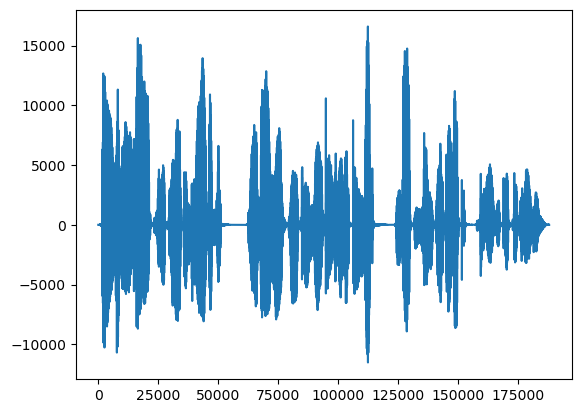

In [10]:
sr, waveform = read_wav(WAV_PATH)
print(sr, waveform.shape)
plt.plot(waveform)

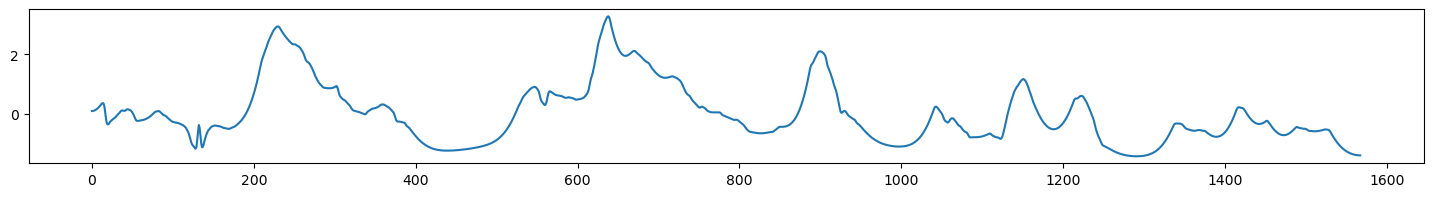

In [11]:
f0_raw = f0_processing.extract_f0(
    waveform=waveform, fs=sr, f0_min=50, f0_max=400, voicing=50
)
f0_interpolated = f0_processing.process(f0_raw)
f0_normalized = normalize_std(f0_interpolated)
f0_normalized.shape

fig = plt.figure(figsize=(18, 2))
ax = fig.add_subplot(111)
ax.plot(f0_normalized)

### Extract energy curve

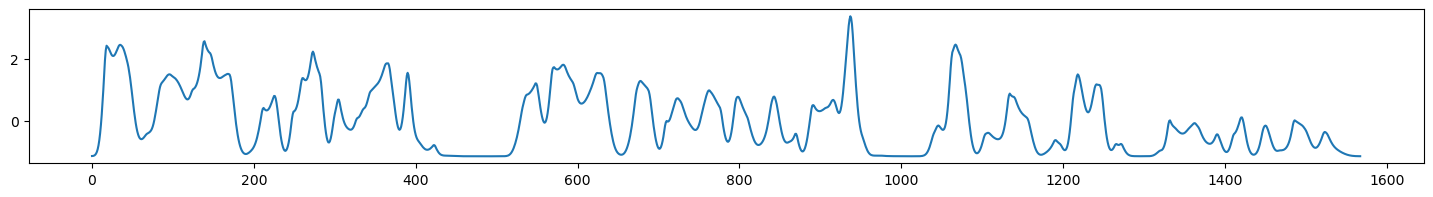

In [12]:
energy = energy_processing.extract_energy(
    waveform=waveform, fs=sr, min_freq=200, max_freq=5000, method="rms"
)
energy_smooth = smooth_and_interp.peak_smooth(
    energy, 30, 3
)  # 30, 3 are fixed in helsinki code
energy_normalized = normalize_std(energy_smooth)
energy_normalized.shape

fig = plt.figure(figsize=(18, 2))
ax = fig.add_subplot(111)
ax.plot(energy_normalized)

### Continuous duration extraction 

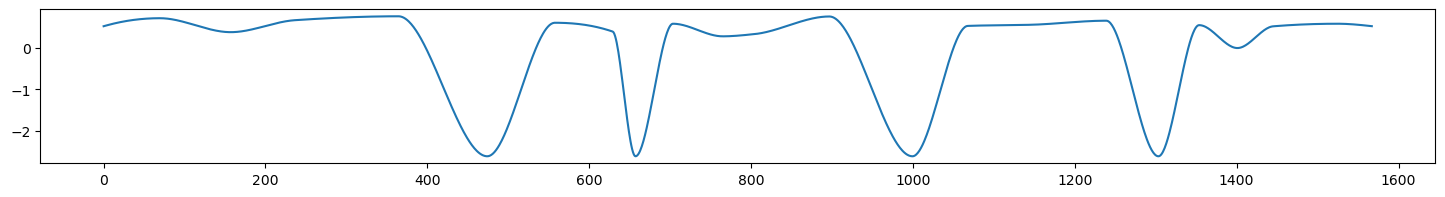

In [13]:
lab_lines = remove_breaks_from_lab_lines(read_lab_file(LAB_PATH))
duration_signal = duration_processing.duration(lab_lines, rate=sr)
duration_norm = normalize_std(duration_signal)

# subsample to correct length
duration_norm = signal.resample(
    duration_norm, min(len(f0_normalized), len(energy_normalized))
)

fig = plt.figure(figsize=(18, 2))
ax = fig.add_subplot(111)
ax.plot(duration_norm)

### Composite prominence Signal 

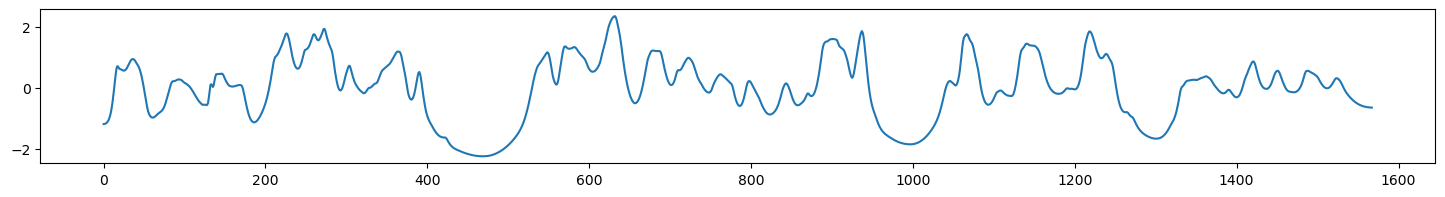

In [14]:
ENERGY_WEIGHT = 1.0
PITCH_WEIGHT = 1.0
DURATION_WEIGHT = 0.5

pitch = f0_normalized[: min(len(f0_normalized), len(energy_normalized))]
energy = energy_normalized[: min(len(f0_normalized), len(energy_normalized))]
duration = duration_norm[: min(len(f0_normalized), len(energy_normalized))]

prominence = PITCH_WEIGHT * pitch + ENERGY_WEIGHT * energy + DURATION_WEIGHT * duration
prominence = smooth_and_interp.remove_bias(prominence, 800)
prominence = normalize_std(prominence)

fig = plt.figure(figsize=(18, 2))
ax = fig.add_subplot(111)
ax.plot(prominence)

In [15]:
# Compute pearson correlation between features
from scipy.stats import pearsonr

print(f"Pearson correlation between pitch and energy: {pearsonr(pitch, energy)[0]}")
print(f"Pearson correlation between pitch and duration: {pearsonr(pitch, duration)[0]}")
print(
    f"Pearson correlation between energy and duration: {pearsonr(energy, duration)[0]}"
)

Pearson correlation between pitch and energy: 0.36794162866822244
Pearson correlation between pitch and duration: 0.3178324348329466
Pearson correlation between energy and duration: 0.4631083652917113


### Per Word Feature Extraction

In [16]:
lab_lines

[[0.03, 0.66, 'also'],
 [0.66, 0.9, 'a'],
 [0.9, 1.45, 'popular'],
 [1.45, 2.17, 'contrivance'],
 [2.54, 3.0, 'whereby'],
 [3.0, 3.25, 'love'],
 [3.28, 3.71, 'making'],
 [3.71, 3.89, 'may'],
 [3.89, 4.1, 'be'],
 [4.1, 4.81, 'suspended'],
 [5.12, 5.49, 'but'],
 [5.49, 5.89, 'not'],
 [5.89, 6.42, 'stopped'],
 [6.53, 6.92, 'during'],
 [6.92, 7.0, 'the'],
 [7.0, 7.36, 'picnic'],
 [7.36, 7.79, 'season']]

In [17]:
def sec_to_idx(sec, sec_max, nb_frames):
    return int((sec / sec_max) * nb_frames)

In [18]:
# Extract pitch curves per word
start = 0.0
end = lab_lines[-1][1]
words = []
word_pitch = []
word_energy = []
word_duration = []
word_prominence = []

for line in lab_lines:
    word_start = line[0]
    word_end = line[1]
    word = line[2]

    words.append(word)
    word_start_idx = sec_to_idx(word_start, end, len(prominence))
    word_end_idx = sec_to_idx(word_end, end, len(prominence))

    word_pitch.append(pitch[word_start_idx:word_end_idx])
    word_energy.append(energy[word_start_idx:word_end_idx])
    word_duration.append(duration[word_start_idx:word_end_idx])
    word_prominence.append(prominence[word_start_idx:word_end_idx])

-0.46863414496577266


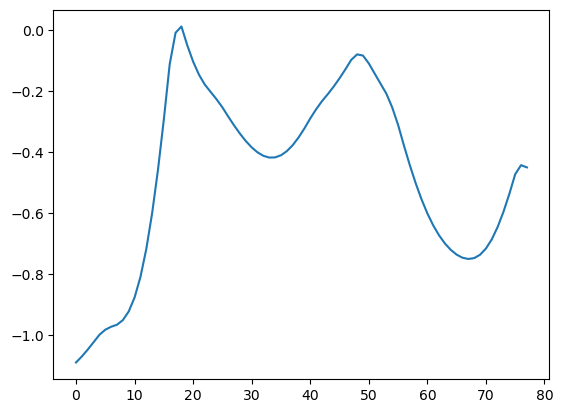

In [22]:
idx = 13
print(np.mean(word_energy[idx]))
plt.plot(word_energy[idx])

### F0 Parameterization

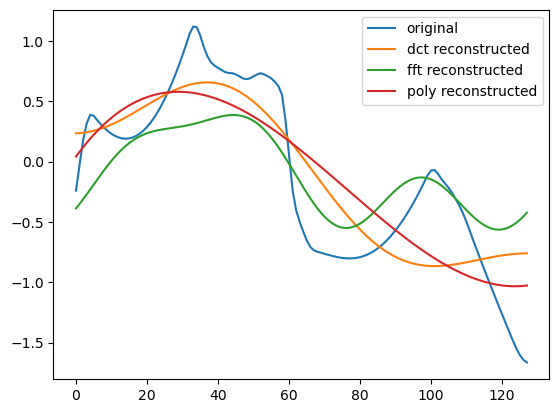

In [89]:
from scipy.fftpack import dct, idct, fft, ifft

signal = word_pitch[3]

coeff_dct = dct(signal, norm="ortho")
coeff_dct[4:] = 0
reconstructed_dct = idct(coeff_dct, norm="ortho")

coeff_fft = fft(signal)
coeff_fft[4:] = 0
reconstructed_fft = ifft(coeff_fft)

coeffs_poly = np.polyfit(np.arange(len(signal)), signal, 3)
reconstructed_poly = np.polyval(coeffs_poly, np.arange(len(signal)))

# plot with legend
plt.plot(signal, label="original")
plt.plot(reconstructed_dct, label="dct reconstructed")
plt.plot(reconstructed_fft, label="fft reconstructed")
plt.plot(reconstructed_poly, label="poly reconstructed")
plt.legend()

### CWT Transform 